In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams
import re, sys, os, glob
import numpy as np
from astropy.io import fits
import pandas as pd
from astropy.table import Table
import astropy.units as u, astropy.constants as c
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

from astroquery.irsa import Irsa
from astropy import units as u
import astropy.coordinates as coord
Irsa.ROW_LIMIT = 10000

import time
import sys

import requests 
from astropy.io.votable import parse_single_table 

from operator import itemgetter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
fits_processing_dictionary = dict([('Z',('ZAPERMAG3','ZAPERMAG3ERR','ZPPERRBITS','MEANMJDOBS')),
                                       ('Y',('YAPERMAG3','YAPERMAG3ERR','YPPERRBITS','MEANMJDOBS')),
                                       ('J',('JAPERMAG3','JAPERMAG3ERR','JPPERRBITS','MEANMJDOBS')),
                                       ('H',('HAPERMAG3','HAPERMAG3ERR','HPPERRBITS','MEANMJDOBS')),
                                       ('K',('KAPERMAG3','KAPERMAG3ERR','KPPERRBITS','MEANMJDOBS')),
                                       ('u',('MJD_U', 'PSFMAG_U', 'PSFMAGERR_U')),
                                       ('g',('MJD_G', 'PSFMAG_G', 'PSFMAGERR_G')),
                                       ('r',('MJD_R', 'PSFMAG_R', 'PSFMAGERR_R')),
                                       ('i',('MJD_I', 'PSFMAG_I', 'PSFMAGERR_I')),
                                       ('z',('MJD_Z', 'PSFMAG_Z', 'PSFMAGERR_Z')),
                                       #('W1',('W1MJDMEAN','W1MAG','W1SIGM','W1FLG')),
                                       #('W2',('W2MJDMEAN','W2MAG','W2SIGM','W2FLG')),
                                       #('W3',('W3MJDMEAN','W3MAG','W3SIGM','W3FLG')),
                                       #('W4',('W4MJDMEAN','W4MAG','W4SIGM','W4FLG'))])
                                       ('W1',('W1MJDMEAN','W1MPRO','W1SIGMPRO','W1SNR','W1RCHI2')),
                                       ('W2',('W2MJDMEAN','W2MPRO','W2SIGMPRO','W2SNR','W2RCHI2')),
                                       ('W3',('W3MJDMEAN','W3MPRO','W3SIGMPRO','W3SNR','W3RCHI2')),
                                       ('W4',('W4MJDMEAN','W4MPRO','W4SIGMPRO','W4SNR','W4RCHI2'))])
    
def combined_fits_processing(fits_in_pandas_data,wise_or_sdss):
        
    "MODIFY IN FUTURE TO APPEND A 'CORRUPTED DATA' TO THE TABLE WHERE DATA IS PRESENT BUT NOT USEABLE"
        
    new_database = []
    for index,row in fits_in_pandas_data.iterrows():
        for wfcam_filter in ['Z','Y','J','H','K']:
            if (row[fits_processing_dictionary[wfcam_filter][0]] > 0 and row[fits_processing_dictionary[wfcam_filter][1]] > 0 and 
                        row[fits_processing_dictionary[wfcam_filter][2]] < 128):                    
                new_database.append((wfcam_filter,row[fits_processing_dictionary[wfcam_filter][3]], 
                                         row[fits_processing_dictionary[wfcam_filter][0]], 
                                         row[fits_processing_dictionary[wfcam_filter][1]]))
        if wise_or_sdss == 'sdss':
            for sdss_filter in ['u','g','r','i','z']:
                new_database.append((sdss_filter,row[fits_processing_dictionary[sdss_filter][0]], 
                                         row[fits_processing_dictionary[sdss_filter][1]], 
                                         row[fits_processing_dictionary[sdss_filter][2]]))            
        if wise_or_sdss == 'wise':
            for wise_filter in ['W1','W2','W3','W4']:
                #if (row[fits_processing_dictionary[wise_filter][2]] > 0 and row[fits_processing_dictionary[wise_filter][3]] < 32):
                if (row[fits_processing_dictionary[wise_filter][2]] > 0 and row[fits_processing_dictionary[wise_filter][3]] > 1 and
                       row[fits_processing_dictionary[wise_filter][4]] < 3):
                    new_database.append((wise_filter,row[fits_processing_dictionary[wise_filter][0]], 
                                         row[fits_processing_dictionary[wise_filter][1]], 
                                         row[fits_processing_dictionary[wise_filter][2]]))
    return new_database


neo_fits_processing_dictionary = dict([('W1',('mjd','w1mpro','w1sigmpro','w1snr','w1rchi2','SOURCEID')),
                                    ('W2',('mjd','w2mpro','w2sigmpro','w2snr','w2rchi2','SOURCEID'))])
    
def neowise_fits_processing(fits_in_pandas_data):
    new_database = []
    for index,row in fits_in_pandas_data.iterrows():
        for wise_filter in ['W1','W2']:
            if (row[neo_fits_processing_dictionary[wise_filter][2]] != 'null' and 
                float(row[neo_fits_processing_dictionary[wise_filter][3]]) > 1 and
                float(row[neo_fits_processing_dictionary[wise_filter][4]]) < 3):
                new_database.append((wise_filter,row[neo_fits_processing_dictionary[wise_filter][0]], 
                                        row[neo_fits_processing_dictionary[wise_filter][1]], 
                                        row[neo_fits_processing_dictionary[wise_filter][2]],
                                        row[neo_fits_processing_dictionary[wise_filter][5]]))
    return new_database


panstarrs_fits_processing_dictionary = dict([('gp1',('epochMean','gMeanPSFMag','gMeanPSFMagErr','gMeanPSFMagStd','gFlags','SOURCEID')),
                                    ('rp1',('epochMean','rMeanPSFMag','rMeanPSFMagErr','rMeanPSFMagStd','rFlags','SOURCEID')),
                                    ('ip1',('epochMean','iMeanPSFMag','iMeanPSFMagErr','iMeanPSFMagStd','iFlags','SOURCEID')),
                                    ('zp1',('epochMean','zMeanPSFMag','zMeanPSFMagErr','zMeanPSFMagStd','zFlags','SOURCEID')),
                                    ('yp1',('epochMean','yMeanPSFMag','yMeanPSFMagErr','yMeanPSFMagStd','yFlags','SOURCEID'))])
                                      
def panstarrs_fits_processing(fits_in_pandas_data):
    new_database = []
    for index,row in fits_in_pandas_data.iterrows():
        for panstarrs_filter in ['gp1','rp1','ip1','zp1','yp1']:
            if (float(row[panstarrs_fits_processing_dictionary[panstarrs_filter][1]]) > 0):
                new_database.append((panstarrs_filter,row[panstarrs_fits_processing_dictionary[panstarrs_filter][0]], 
                                        row[panstarrs_fits_processing_dictionary[panstarrs_filter][1]], 
                                        row[panstarrs_fits_processing_dictionary[panstarrs_filter][2]],
                                        row[panstarrs_fits_processing_dictionary[panstarrs_filter][5]]))
    return new_database

In [3]:
def combined_mag_modification(fits_in_pandas_data):
    filter_dict = {'Z':(0.528,0.8817*u.micrometer),'Y':(0.634,1.0305*u.micrometer),'J':(0.938,1.2483*u.micrometer),
                       'H':(1.379,1.6313*u.micrometer),'K':(1.900,2.2010*u.micrometer),
                       'u':(-0.04,3551*u.Angstrom,1.4*10**(-10)), 'g':(0,4686*u.Angstrom,0.9*10**(-10)), 
                       'r':(0,6166*u.Angstrom,1.2*10**(-10)), 'i':(0,7480*u.Angstrom,1.8*10**(-10)), 
                       'z':(0.02,8932*u.Angstrom,7.4*10**(-10)),
                       'W1':(309.54,3.4 *u.micrometer,2.699,0.03), 'W2':(171.787,4.6 *u.micrometer,3.339,0.04), 
                       'W3':(31.674,12 *u.micrometer,5.174,0.03), 'W4':(8.363,22 *u.micrometer,6.620,-0.03),
                       'gp1':(0,481*u.nanometer),'rp1':(0,617*u.nanometer),'ip1':(0,752*u.nanometer),
                       'zp1':(0,866*u.nanometer),'yp1':(0,962*u.nanometer)}
    new_database = []
    for index,row in fits_in_pandas_data.iterrows():
        if row['filter'] == 'Z' or row['filter'] == 'Y' or row['filter'] == 'J' or row['filter'] == 'H' or row['filter'] == 'K':
            new_mag = (row.flux+filter_dict[row['filter']][0])
            #new_flux=10**((new_mag+48.60)/-2.5) \This is in units of erg s^-1 cm^-2 Hz^-1\
            new_flux=10**(new_mag/-2.5) * 3631 * u.Jansky #This is units of jansky's
            #new_err = 3631 * u.Jansky * np.abs(-0.921034*np.exp(-0.921034*new_mag)) * row.err
            "New error equation - jansky's are hard to handle"
            #new_err = row.err * new_flux / 1.09
            "APARENTLY MAGMITUDES ARE VEGA-LIKE TO WITHIN 2% - ADD A 2% ERR"
            new_err = np.sqrt((0.02 * new_mag)**2 + row.err**2)
            new_err = new_err * new_flux / 1.09
            ab_mag=new_mag
                
            new_database.append((row['filter'],row.date,ab_mag,row.err,new_flux,new_err,row['#id'],filter_dict[row['filter']][1]))
        elif row['filter'] == 'u' or row['filter'] == 'g' or row['filter'] == 'r' or row['filter'] == 'i' or row['filter'] == 'z':
            "For SDSS, the slight magnitude adjustments are not precise to better than 0.01 mag"
            new_mag = (row.flux+filter_dict[row['filter']][0])
            #new_flux = (new_mag * np.log(10) / -2.5) - np.log(filter_dict[row['filter']][2])
            #new_flux = np.sinh(new_flux) * 2 * filter_dict[row['filter']][2] * 3631 * u.Jansky
            #new_err = 2 * filter_dict[row['filter']][2] * 3631 * u.Jansky * np.abs(-0.921034*(
            #            np.cosh(-0.921034*new_mag - np.log(filter_dict[row['filter']][2])))) * row.err
            "THE BELOW WAS TAKEN FROM A PAPER - https://arxiv.org/pdf/astro-ph/0508564.pdf"
            "SEEMS TO BE WRONG!!!!"
            new_flux = (-new_mag / (2.5 / np.log(10))) - np.log(filter_dict[row['filter']][2])
            new_flux = np.sinh(new_flux) * 2 * filter_dict[row['filter']][2] * 3631 * u.Jansky
            #new_err = 2 * 3631 * u.Jansky * row.err / (2.5 / np.log(10))
            #new_err = new_err * np.sqrt((np.sinh(temp))**2 + (filter_dict[row['filter']][2])**2)
            #new_err = 2*3631 * u.Jansky*row.err/1.08 * math.sqrt(math.sinh(-new_mag/1.08 - math.log(filter_dict[row['filter']][2]))**2 + 
            #                                                     (filter_dict[row['filter']][2])**2)
            if row['filter'] == 'u' or row['filter'] == 'z':
                new_err = np.sqrt((0.01)**2 + row.err**2)
            else:
                new_err=row.err
            new_err = 2 * filter_dict[row['filter']][2] * 3631 * u.Jansky * np.abs(-0.921034*(
                        np.cosh(-0.921034*new_mag - np.log(filter_dict[row['filter']][2])))) * new_err
            ab_mag=new_mag
                
            new_database.append((row['filter'],row.date,ab_mag,row.err,new_flux,new_err,row['#id'],filter_dict[row['filter']][1]))
        elif row['filter'] == 'W1' or row['filter'] == 'W2' or row['filter'] == 'W3' or row['filter'] == 'W4':
            #new_mag = (row.flux+filter_dict[row['filter']][3]) #Modification mentioned in Jarrett et al 2012
            new_mag = (row.flux) #Modification is for large well resolved sources, removed
               
            new_flux = 10**(new_mag/-2.5) * filter_dict[row['filter']][0] * u.Jansky
            new_flux = 10**(new_mag/-2.5) * filter_dict[row['filter']][0]
            
            #new_err = filter_dict[row['filter']][0] * np.abs(-0.921034*np.exp(-0.921034*row.flux)) * row.err
            new_err = np.abs(-0.921034*np.exp(-0.921034*row.flux)) * row.err
            #new_err = row.err * new_flux / 1.09
            
            new_err = new_flux * math.sqrt((0.015)**2 + (new_err/10**(new_mag/-2.5))**2) #error in flux base points
            
            if row['filter'] == 'W4':
                new_flux = new_flux * (1.0-0.09) # Flux is 9% too low in W4
            if row['filter'] == 'W4' or row['filter'] == 'W3':
                new_err = np.sqrt((0.1 * new_flux)**2 + new_err**2)
                
            ab_mag = new_mag+filter_dict[row['filter']][2]
            "Still need to convert ab magnitudes errors"
                        
            new_database.append((row['filter'],row.date,ab_mag,row.err,new_flux*u.Jansky,new_err*u.Jansky,row['#id'],filter_dict[row['filter']][1]))
        else:
            ab_mag=row.flux
            new_flux=10**(ab_mag/-2.5) * 3631 #This is units of jansky's
            new_err = float(row.err) * new_flux / 1.09
            new_database.append((row['filter'],row.date,ab_mag,row.err,new_flux*u.Jansky,new_err*u.Jansky,row['#id'],filter_dict[row['filter']][1]))
    return new_database

In [4]:
dat = Table.read('results_variables_only_and_sdss_with_dates.fits', format='fits')
sdss_df = dat.to_pandas()
dat = Table.read('results_wise_sigmapro.fits', format='fits')
wise_df = dat.to_pandas()
found_variable_stars = pd.read_csv('result.csv')

dat = Table.read('wfcam_only.fits', format='fits')
wfcam_only_df = dat.to_pandas()


ids = np.unique(sdss_df.SOURCEID)
magnitude_table = pd.DataFrame()
for source_id in ids:
    number_of_measurements = len(sdss_df.loc[sdss_df.SOURCEID==source_id])
    if number_of_measurements > 10:
        formatted_data_pandas=pd.DataFrame(combined_fits_processing(sdss_df.loc[sdss_df.SOURCEID==source_id],'sdss'),
                                               columns=['filter','date','flux','err'])
        formatted_data_pandas['#id'] = pd.Series(source_id, index=formatted_data_pandas.index)
        magnitude_table = pd.concat([magnitude_table,formatted_data_pandas])
            
ids = np.unique(wise_df.SOURCEID)
for source_id in ids:
    number_of_measurements = len(wise_df.loc[wise_df.SOURCEID==source_id])
    if number_of_measurements > 10:
        formatted_data_pandas=pd.DataFrame(combined_fits_processing(wise_df.loc[wise_df.SOURCEID==source_id],'wise'),
                                               columns=['filter','date','flux','err'])
        formatted_data_pandas['#id'] = pd.Series(source_id, index=formatted_data_pandas.index)
        magnitude_table = pd.concat([magnitude_table,formatted_data_pandas])

ids = np.unique(wfcam_only_df.SOURCEID)
for source_id in ids:
    number_of_measurements = len(wfcam_only_df.loc[wfcam_only_df.SOURCEID==source_id])
    if number_of_measurements > 10:
        formatted_data_pandas=pd.DataFrame(combined_fits_processing(wfcam_only_df.loc[wfcam_only_df.SOURCEID==source_id],'neither'),
                                               columns=['filter','date','flux','err'])
        formatted_data_pandas['#id'] = pd.Series(source_id, index=formatted_data_pandas.index)
        magnitude_table = pd.concat([magnitude_table,formatted_data_pandas]) 

magnitude_table = magnitude_table.drop_duplicates()

In [5]:
"""NEW SECTION INCORPORATING NEOWISE"""
start_time = time.time()
write_yes = False
if write_yes != True:
    sys.exit()

dat = Table.read('allwise_proper.fits', format='fits')
cntr_values = dat['CNTR']

allwise_df = dat.to_pandas()
allwise_df['CNTR'] = cntr_values

allwise_df['RA'] = (allwise_df['RA'].values*u.radian).to(u.degree)  #Conversion to degrees
allwise_df['DEC'] = (allwise_df['DEC'].values*u.radian).to(u.degree)
"This introduces errors of order < 0.00001"

breaker=0
"ADD IN:"
"qual_frame>0 and qi_fact>0 and saa_sep>0 and moon_masked=0 check"
"only qual_frame can be checked, but cc_flags will be used to remove spurious detections"

neowise_data_to_write = pd.DataFrame()

for ra,dec,sourceid,cntr in zip(allwise_df['RA'].values,allwise_df['DEC'].values,
                                allwise_df['SOURCEID'].values,allwise_df['CNTR'].values):
    if breaker > 300:
        break

    c=coord.SkyCoord(ra,dec,unit=(u.deg,u.deg),frame='icrs')
    
    table = Irsa.query_region(c, catalog='neowiser_p1bs_psd', spatial="Cone", radius=5 * u.arcsecond)
    neowise_df = table.to_pandas()
    table_section=neowise_df.loc[neowise_df['allwise_cntr'].str.decode('UTF-8')==str(int(cntr))]
    
    if len(table_section) < 1:
        table = Irsa.query_region(c, catalog='neowiser_p1bs_psd', spatial="Cone", radius=20 * u.arcsecond)
        neowise_df = table.to_pandas()
        table_section=neowise_df.loc[neowise_df['allwise_cntr'].str.decode('UTF-8')==str(int(cntr))]
    
    if len(table_section) >= 1:
        
        table_section=table_section.loc[table_section['qual_frame'] > 0.0]
        table_section=table_section.loc[table_section['cc_flags'] == b'0000']
        table_section['SOURCEID'] = pd.Series(sourceid, index=table_section.index)
    
        formatted_data_pandas=pd.DataFrame(neowise_fits_processing(table_section),columns=['filter','date','flux','err','#id'])
        neowise_data_to_write = pd.concat([neowise_data_to_write,formatted_data_pandas])
    
    else:
        print("something wrong at: " + str(source_id) + ", " + str(cntr) + " " + str(ra) + " " + str(dec) + " " + str(c))
    breaker += 1
    
np.savetxt('neowise_tablulated_data.txt', neowise_data_to_write.values,fmt='%5s',delimiter=',')
"CHECK WHETHER THIS FORMAT 5s DOES NOT LOSE INFO"
print("--- %s seconds ---" % (time.time() - start_time))

SystemExit: 

C:\Users\Aaron\Anaconda3\envs\NewPhDEnv\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
"""NEW SECTION INCORPORATING PanStarrs"""
start_time = time.time()
write_yes = False
if write_yes != True:
    sys.exit()

dat = Table.read('wfcam_positions_for_panstarrs.fits', format='fits')

wfcam_pos_df = dat.to_pandas()
"This one does not convert assume the table is in radians, and thus manual conversion is not needed"

def panstarrs_query(ra_deg, dec_deg, rad_deg, mindet=1, 
                    maxsources=10000,
                    server=('https://archive.stsci.edu/'+
                            'panstarrs/search.php')): 
    """
    Query Pan-STARRS DR1 @ MAST
    parameters: ra_deg, dec_deg, rad_deg: RA, Dec, field 
                                          radius in degrees
                mindet: minimum number of detection (optional)
                maxsources: maximum number of sources
                server: servername
    returns: astropy.table object
    """
    r = requests.get(server, 
    params= {'RA': ra_deg, 'DEC': dec_deg,
             'SR': rad_deg, 'max_records': maxsources, 
             'outputformat': 'VOTable', 
             'ndetections': ('>%d' % mindet)}) 
 
    # write query data into local file
    outf = open('panstarrs.xml', 'w') 
    outf.write(r.text) 
    outf.close() 
 
    # parse local file into astropy.table object 
    data = parse_single_table('panstarrs.xml')
    return data.to_table(use_names_over_ids=True)

breaker=0

panstarrs_data_to_write = pd.DataFrame()

for index,row in wfcam_pos_df.iterrows():
    if breaker > 350:
        break
    
    table=panstarrs_query(row.WFCAM_RA,row.WFCAM_DEC,0.00139)
    neowise_df = table.to_pandas()
    table_section=neowise_df
    
    if len(table_section) < 1:
        table=panstarrs_query(row.WFCAM_RA,row.WFCAM_DEC,5*0.00139)
        neowise_df = table.to_pandas()
        table_section=neowise_df
    
    if len(table_section) >= 1:
        
        table_section['SOURCEID'] = pd.Series(row.SOURCEID, index=table_section.index)
        
        "NEW QUALITY CHECKS"
        table_section = table_section.drop(table_section[table_section["Ang Sep (')"] > 0.03].index)
        "Taking the nearest couple of objects, within a certain region"
        
        "Taking the objects with a good PSF fit in at least 3 wavebands"
        for index,row in table_section.iterrows():
            count_data_exists = 0
            for waveband_flag in ['gQfPerfect','rQfPerfect','iQfPerfect','zQfPerfect','yQfPerfect']:
                if row[waveband_flag] > 0.85:
                    count_data_exists += 1
            if count_data_exists >= 3:
                table_section = table_section.drop(table_section[table_section.index != index].index)
                break
            else:
                table_section = table_section.drop(index)
        "0.85 limit is used in https://arxiv.org/pdf/1612.05242.pdf"
        
        "Also add another check used in https://arxiv.org/pdf/1612.05242.pdf - pg 9"
        "Using the difference between psf and kron magnitudes to rule out galaxies"
        
        #"Only taking the first row to select the closest matching point"
        #formatted_data_pandas=pd.DataFrame(panstarrs_fits_processing(table_section[:1]),
        #                                   columns=['filter','date','flux','err','#id'])
        
        formatted_data_pandas=pd.DataFrame(panstarrs_fits_processing(table_section),
                                           columns=['filter','date','flux','err','#id'])
        panstarrs_data_to_write = pd.concat([panstarrs_data_to_write,formatted_data_pandas])
    
    else:
        print("something wrong at: " + str(row))
    breaker += 1
    
np.savetxt('panstarrs_tablulated_data.txt', panstarrs_data_to_write.values,fmt='%5s',delimiter=',')
"CHECK WHETHER THIS FORMAT 5s DOES NOT LOSE INFO"
print("--- %s seconds ---" % (time.time() - start_time))

In [6]:
neowise_table=(pd.read_csv('neowise_tablulated_data.txt',names=['filter','date','flux','err','#id']))
neowise_table['filter']=neowise_table['filter'].str.strip()
neowise_table['err']=neowise_table['err'].astype(float)
magnitude_table=magnitude_table.append(neowise_table)

panstarrs_table=(pd.read_csv('panstarrs_tablulated_data.txt',names=['filter','date','flux','err','#id']))
panstarrs_table['filter']=panstarrs_table['filter'].str.strip()
magnitude_table=magnitude_table.append(panstarrs_table)

print(magnitude_table['filter'].value_counts())

J      30036
K      29912
H      27730
Y      26021
Z      24350
W2     14471
W1     13973
ip1      308
zp1      308
yp1      308
rp1      305
gp1      294
r        117
u        117
z        117
i        117
g        117
W3        98
W4        41
Name: filter, dtype: int64


In [17]:
def primary_visualizer_all_data(number_to_visualize):
    graphs_displayed = 0
    for variable_ids in set(found_variable_stars.WSA).intersection(magnitude_table['#id']):
        if graphs_displayed >= number_to_visualize:
            break
        table_section = magnitude_table.loc[magnitude_table['#id']==variable_ids]
        csv_section = found_variable_stars.loc[found_variable_stars['WSA']==variable_ids]
        
        "CHECK FOR CORRUPTED DATA IN DATASET"
        #Z_check,Y_check,J_check,H_check,k_check,W1_check,W2_check,W3_check,W4_check = 
        #False,False,False,False,False,False,False,False,False
        #u_check,g_check,r_check,i_check,z_check = False,False,False,False,False
        #check_dict = dict([('Z',Z_check),('Y',Y_check),('J',J_check), ('H',H_check),('k',k_check),
        #                   ('W1',W1_check),('W2',W2_check),('W3',W3_check),('W4',W4_check),
        #                    ('u',u_check),('g',g_check),('r',r_check),('i',i_check),('z',z_check)])
        #for test_filter in np.unique(table_section['filter']):
        #    corrupt_check_df=table_section.loc[table_section['filter']==test_filter]
        #    nan = corrupt_check_df[corrupt_check_df.isnull().any(axis=1)].index
        #    if len(nan) > 0:
        #        check_dict[test_filter] == True
        #table_section = table_section.dropna(axis=0, thresh=2)    
        
        "INSERT A FLAG HERE TO DENOTE WHAT PATH IS TAKEN"
        path_flag = 0
            
        new_flux = pd.DataFrame(combined_mag_modification(table_section),
                                columns=['filter','date','mag','magerr','flux','err','#id','band_central_wavelength']) 
                 
        "phase all the periods according to the period from the csv file"
        period = csv_section['Per'].values
        phased_periods = np.mod(np.array(new_flux['date']),period)
        phased_periods = np.multiply(phased_periods,(1/period))
        if period[0] == period[0]:
            new_flux['phased_date'] = pd.Series(phased_periods, index=new_flux.index)
            path_flag = 0
        else:
            path_flag = 2
            new_flux['phased_date'] = pd.Series(new_flux['date'], index=new_flux.index)
                
        "Adjust the magnitudes down by the average so they are plotted overlapping"           
        new_average_magnitude_dict = dict([('Z',np.mean(new_flux.loc[new_flux['filter']=='Z']['mag'])),
                                               ('Y',np.mean(new_flux.loc[new_flux['filter']=='Y']['mag'])),
                                               ('J',np.mean(new_flux.loc[new_flux['filter']=='J']['mag'])),
                                               ('H',np.mean(new_flux.loc[new_flux['filter']=='H']['mag'])),
                                               ('K',np.mean(new_flux.loc[new_flux['filter']=='K']['mag'])),
                                                ('W1',np.mean(new_flux.loc[new_flux['filter']=='W1']['mag'])),
                                                ('W2',np.mean(new_flux.loc[new_flux['filter']=='W2']['mag'])),
                                                ('W3',np.mean(new_flux.loc[new_flux['filter']=='W3']['mag'])),
                                                ('W4',np.mean(new_flux.loc[new_flux['filter']=='W4']['mag'])),
                                                ('u',np.mean(new_flux.loc[new_flux['filter']=='u']['mag'])),
                                                ('g',np.mean(new_flux.loc[new_flux['filter']=='g']['mag'])),
                                                ('r',np.mean(new_flux.loc[new_flux['filter']=='r']['mag'])),
                                                ('i',np.mean(new_flux.loc[new_flux['filter']=='i']['mag'])),
                                                ('z',np.mean(new_flux.loc[new_flux['filter']=='z']['mag'])),
                                           ('gp1',np.mean(new_flux.loc[new_flux['filter']=='gp1']['mag'])),
                                           ('rp1',np.mean(new_flux.loc[new_flux['filter']=='rp1']['mag'])),
                                           ('ip1',np.mean(new_flux.loc[new_flux['filter']=='ip1']['mag'])),
                                           ('zp1',np.mean(new_flux.loc[new_flux['filter']=='zp1']['mag'])),
                                           ('yp1',np.mean(new_flux.loc[new_flux['filter']=='yp1']['mag']))])
    
        "See version 19.02.2018 for the commented out version which used the vega mags from the original files"
        "In current version, ab magnitudes are used at all points"
        
        "Calculate the reduced magnitudes for all data - point minus waveband mean"
        "Display all data points, with color depending on waveband as time/phase vs magnitude"
        "Display all data points, with color depending on waveband as time/phase vs reduced magnitude"
        reduced_magnitudes = []
        for index,row in new_flux.iterrows():
            reduced_magnitudes.append(row['mag'] - new_average_magnitude_dict[row['filter']])
        new_flux['reduced_mag'] = pd.Series(reduced_magnitudes, index=new_flux.index)
            
        temp_colours = cm.rainbow(np.linspace(0, 1, 19))
        colors_dict = dict([('Z',temp_colours[0]),('Y',temp_colours[1]),('J',temp_colours[2]), ('H',temp_colours[3]),
                            ('K',temp_colours[4]),('u',temp_colours[5]),('g',temp_colours[6]),
                            ('r',temp_colours[7]),('i',temp_colours[8]),('z',temp_colours[9]),
                            ('W1',temp_colours[10]),('W2',temp_colours[11]),('W3',temp_colours[12]),
                            ('W4',temp_colours[13]),('gp1',temp_colours[14]),('rp1',temp_colours[15]),
                            ('ip1',temp_colours[16]),('zp1',temp_colours[17]),('yp1',temp_colours[18])])
        f, axarr = plt.subplots(3, sharex=False, figsize=(6, 12))
        if path_flag < 2:
            for graph_filter,x,y,y2 in zip(new_flux['filter'].values,phased_periods,
                                          new_flux['mag'].values,reduced_magnitudes):
                axarr[0].scatter(x,y,label=graph_filter,color = colors_dict[graph_filter])
                axarr[1].scatter(x,y2,label=graph_filter,color = colors_dict[graph_filter])
        else:
            for graph_filter,x,y,y2 in zip(new_flux['filter'].values,new_flux['date'],
                                           new_flux['mag'].values,reduced_magnitudes):
                axarr[0].scatter(x,y,label=graph_filter,color = colors_dict[graph_filter])
                axarr[1].scatter(x,y2,label=graph_filter,color = colors_dict[graph_filter])
                "COMMENT THIS OUT FOR BETTER VISIBILITY OF SELECTED REGIONS"
        
        
        roots_dict = dict([(0,'o'),(1,'D'),(2,'s'),(3,'2'),(4,'4'),(5,'8'),(6,'h'),(7,'p'),(8,'*'),(9,'.'),
                               (10,'p'),(11,'D'),(12,'s'),(13,'2'),(14,'4'),(15,'8'),(16,'h'),(17,'p'),(18,'.'),
                              (19,'v')])
        roots_list=[]
        for p in roots_dict.items():
            roots_list.append(p[1])
        
        for panstarrs_filter in ['gp1','rp1','ip1','zp1','yp1']:
            panstarrs_epoch_data = new_flux.loc[new_flux['filter']==panstarrs_filter]
            if len(panstarrs_epoch_data) > 0:
                #roots=np.append(roots,panstarrs_epoch_data['phased_date'])
                roots=panstarrs_epoch_data['phased_date']
                axarr[1].scatter(panstarrs_epoch_data['phased_date'],0,s=35,marker=roots_dict[0],color='r')
                break
                
        for sdss_filter in ['u','g','r','i','z']:
            sdss_epoch_data = new_flux.loc[new_flux['filter']==sdss_filter]
            if len(sdss_epoch_data) > 0:
                roots=np.append(roots,sdss_epoch_data['phased_date'])
                axarr[1].scatter(sdss_epoch_data['phased_date'],0,s=35,marker=roots_dict[1],color='c')
                break
                
        #for wise_filter in ['W3']:
        #    wise_epoch_data = new_flux.loc[new_flux['filter']==wise_filter]
        #    if len(wise_epoch_data) > 0:
        #        roots=np.append(roots,wise_epoch_data['phased_date'])
        #        axarr[1].scatter(wise_epoch_data['phased_date'],1,s=30,marker=roots_dict[1],color='g')
        #        break
        
        size=24
        if path_flag < 2:
            "If the object is periodic, used the phased periods and mags to find interesting points"
            sorted_reduced_mags = [x for _,x in sorted(zip(phased_periods,reduced_magnitudes))]
            sorted_phased_periods = sorted(phased_periods)
            #test_spline = UnivariateSpline(sorted_phased_periods, sorted_reduced_mags,k=4,s=5e8)
        else:
            "If not periodic, use the normal unphased light curve"
            sorted_reduced_mags = [x for _,x in sorted(zip(new_flux['date'],reduced_magnitudes))]
            sorted_phased_periods = sorted(new_flux['date'])
             
        
        test_spline = UnivariateSpline(sorted_phased_periods, sorted_reduced_mags,k=4,s=5e8)
        if math.isnan(test_spline(sorted_phased_periods)[0]) != True and period[0] == period[0]:
            path_flag=0
            axarr[1].plot(sorted_phased_periods,test_spline(sorted_phased_periods),color='k')
            deriv_spline=test_spline.derivative()
            roots = np.append(roots, deriv_spline.roots())
            for x1,y1,mark in zip(roots,test_spline(roots),roots_list):
                axarr[1].scatter(x1,y1,label='roots',color='k',s=size,marker=mark)
        else:
            fixed_columns=['filter','date','mag','err','#id','band_central_wavelength']
            low_list=pd.DataFrame(columns=fixed_columns);high_list=pd.DataFrame(columns=fixed_columns)
            x=reduced_magnitudes
            max_value_list=[];min_value_list=[]
            "TEMPORAILY ADJUSTING FROM 10 TO SEE IF LESS REPEATS OCCUR"
            for max_value in np.argpartition(x, -7)[-7:]:
                high_list = pd.concat([high_list,pd.DataFrame(new_flux.iloc[max_value]).transpose()])
                max_value_list.append(max_value)
            for min_value in np.argpartition(x, 7)[:7]:
                low_list = pd.concat([low_list,pd.DataFrame(new_flux.iloc[min_value]).transpose()])
                min_value_list.append(min_value)
            
            #if path_flag < 2:
            #    path_flag=1
            #    max_phase = np.multiply(np.mod(np.array(high_list['date']),period),(1/period))
            #    min_phase = np.multiply(np.mod(np.array(low_list['date']),period),(1/period))
            #    "More modification to plot all magnitudes as ab mag"
            #    for x1,y1,y2,mark in zip(max_phase,high_list['mag'],[x[i] for i in max_value_list],roots_list[0:9]):
            #        axarr[0].scatter(x1,y1,label='max',color='k',s=size,marker=mark)
            #        axarr[1].scatter(x1,y2,label='max',color='k',s=size,marker=mark)
            #    for x1,y1,y2,mark in zip(min_phase,low_list['mag'],[x[i] for i in min_value_list],roots_list[10:19]):
            #        axarr[0].scatter(x1,y1,label='min',color='k',s=size,marker=mark)
            #        axarr[1].scatter(x1,y2,label='min',color='k',s=size,marker=mark)
            #    roots=np.append(max_phase,min_phase)
            #else:
            #    max_periods = np.array(high_list['date'])
            #    min_periods = np.array(low_list['date'])
            #    "More modification to plot all magnitudes as ab mag"
            #    for x1,y1,y2,mark in zip(max_periods,high_list['mag'],[x[i] for i in max_value_list],roots_list[0:9]):
            #        axarr[0].scatter(x1,y1,label='max',color='k',s=size,marker=mark)
            #        axarr[1].scatter(x1,y2,label='max',color='k',s=size,marker=mark)
            #    for x1,y1,y2,mark in zip(min_periods,low_list['mag'],[x[i] for i in min_value_list],roots_list[10:19]):
            #        axarr[0].scatter(x1,y1,label='min',color='k',s=size,marker=mark)
            #        axarr[1].scatter(x1,y2,label='min',color='k',s=size,marker=mark)
            #    roots=np.append(np.array(max_periods),np.array(min_periods))
                
            if path_flag < 2:
                path_flag=1
                max_times = np.multiply(np.mod(np.array(high_list['date']),period),(1/period))
                min_times = np.multiply(np.mod(np.array(low_list['date']),period),(1/period))
            else:
                max_times = np.array(high_list['date'])
                min_times = np.array(low_list['date'])
                
            for x1,y1,y2,mark in zip(max_times,high_list['mag'],[x[i] for i in max_value_list],roots_list[0:9]):
                axarr[0].scatter(x1,y1,label='max',color='k',s=size,marker=mark)
                axarr[1].scatter(x1,y2,label='max',color='k',s=size,marker=mark)
            for x1,y1,y2,mark in zip(min_times,low_list['mag'],[x[i] for i in min_value_list],roots_list[10:19]):
                axarr[0].scatter(x1,y1,label='min',color='k',s=size,marker=mark)
                axarr[1].scatter(x1,y2,label='min',color='k',s=size,marker=mark)
            roots=np.append(roots,np.append(max_times,min_times))
        "END COMPILING INTERESTING OBJECTS"
        
        axarr[0].invert_yaxis()
        handles, labels = axarr[1].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        available_keys = [k for k in ['J','K','H','Y','Z','W1','W2','W3','W4',
                                     'ip1','zp1','yp1','rp1','gp1','r','g','u','z','i','roots','max','min'] if k in by_label]
        available_values = itemgetter(*available_keys)(by_label)
        axarr[1].legend(available_values, available_keys, bbox_to_anchor=(1.25, 1.9),ncol=1, fancybox=True, shadow=True)
        
        
        sed_colours = cm.rainbow(np.linspace(0, 1, len(roots)))
        #sed_colors = dict([(0,temp_colours[0]),(1,temp_colours[1]),(2,temp_colours[2]), (3,temp_colours[3]),
        #                    (4,temp_colours[4]),(5,temp_colours[5]),(6,temp_colours[6])])
        
        "BEGIN LOOP OVER INTERESTING POINTS"
        for root_number,root in enumerate(np.unique(roots)):
            temp_objects = pd.DataFrame()
            for counter,current_period in enumerate(sorted_phased_periods):
                if path_flag < 2:
                    if np.abs(current_period - root) < 0.04:
                        temp_objects=pd.concat([temp_objects,new_flux.loc[new_flux['phased_date']==current_period]])
                else:
                    if np.abs(current_period - root) < ((max(new_flux['date'])-min(new_flux['date']))/170):
                        temp_objects=pd.concat([temp_objects,new_flux.loc[new_flux['date']==current_period]])
            #height_mean = np.mean(temp_objects['reduced_mag'])
            #height_std = np.std(temp_objects['reduced_mag'])
            #height_clipped_objects = pd.DataFrame()
            #for index,row in temp_objects.iterrows():
            #    if np.abs(row['reduced_mag'] - height_mean) < height_std:
            #        height_clipped_objects=pd.concat([height_clipped_objects,pd.DataFrame(row).transpose()])
            
                
            if len(temp_objects) != 0:
                
                time_clipped_temp_objects=temp_objects
                #time_clipped_temp_objects=height_clipped_objects
                                
                for test_filter in np.unique(time_clipped_temp_objects['filter']):
                    #if (test_filter != 'Z' and test_filter != 'Y' and test_filter != 'J' and test_filter != 'H' 
                    #        and test_filter != 'K' and test_filter != 'W1' and test_filter != 'W2'):
                    #    continue
                    single_filter_plotting_data = time_clipped_temp_objects.loc[time_clipped_temp_objects['filter']==
                                                                     test_filter]
                        
                    flux_point=np.mean(single_filter_plotting_data['flux'])/(1. * u.Jansky)
                    wave_point=(np.mean(single_filter_plotting_data['band_central_wavelength']).to(u.Angstrom))/(1. * u.Angstrom)
                    mean_error=0;weighted_mean=0;weighted_err=0
                    for index,row in single_filter_plotting_data.iterrows():
                        mean_error += (row['err']/(1. * u.Jansky))**2
                        
                        #weighted_mean += (row['flux']/(1. * u.Jansky) * (1/(row['err']/(1. * u.Jansky))**2))
                        #weighted_err += (1/(row['err']/(1. * u.Jansky))**2)
                        
                    #flux_point = weighted_mean/weighted_err
                    #mean_error = numpy.sqrt(1/weighted_err)
                    #plt.errorbar(wave_point,flux_point,mean_error,ls='None',marker=roots_dict[root_number],
                    #             label=test_filter,color=colors_dict[test_filter])
                                
                    #axarr[2].errorbar(wave_point,flux_point,((mean_error)**0.5)/len(single_filter_plotting_data),ls='None',
                    #                  marker=roots_dict[root_number],label=test_filter,color=colors_dict[test_filter])
                    axarr[2].errorbar(wave_point,flux_point,((mean_error)**0.5)/len(single_filter_plotting_data),ls='None',
                                      marker='o',label=root,color=sed_colours[root_number])
                    
                    "Insert a print statement to get data for testing VOSA"
                    print(test_filter,flux_point,((mean_error)**0.5)/len(single_filter_plotting_data))
        
            "Adding a break point to show end of single root dataset for testing VOSA"
            print("end root data")
            print(variable_ids)
        
        "END LOOP OVER EACH INTERESTING POINT FOUND"
        
        #for test_filter in np.unique(new_flux['filter']):
        #    list_of_flux_points = [];list_of_wave = [];list_of_flux_errors = []
        #    if (test_filter != 'Z' and test_filter != 'Y' and test_filter != 'J' and test_filter != 'H' and 
        #                        test_filter != 'K' and test_filter != 'W1' and test_filter != 'W2' and test_filter != 'W4'):
        #        list_of_flux_points.append(np.mean(new_flux.loc[new_flux['filter']==test_filter]['flux'])/(1. * u.Jansky))
        #        list_of_wave.append((np.mean(new_flux.loc[new_flux['filter']==test_filter]['band_central_wavelength']).
        #                              to(u.Angstrom))/(1. * u.Angstrom))
        #        mean_error=0
        #        for index,row in new_flux.loc[new_flux['filter']==test_filter].iterrows():
        #            mean_error += (row['err']/(1. * u.Jansky))**2
        #        list_of_flux_errors.append(mean_error**0.5)
        #        axarr[2].errorbar(list_of_wave,list_of_flux_points,list_of_flux_errors,ls='None', marker='o',
        #                     label=test_filter,color=colors_dict[test_filter])

        axarr[2].set_xscale('log');axarr[2].set_yscale('log')
        axarr[2].set_xlabel('Wavelength, Angstroms')
        axarr[0].set_ylabel('Magnitude')
        axarr[1].set_ylabel('Reduced Magnitude')
        axarr[1].set_xlabel('Phased Period/Period')
        axarr[2].set_ylabel('Flux, Janskys')
        axarr[0].set_title("Type: " + str(csv_section['Type'].values) + ", Period: " + str(period) + " days, with " + 
                           str(root_number+1) + " roots found. WFCAM Object ID: " + str(variable_ids))
        #axarr[2].set_title("SED - flux vs wavelength, with " + str(root_number+1) + " roots")
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        #by_label = dict(zip(labels, handles))
        #available_keys = [k for k in ['J','K','H','Y','Z','W1','W2','W3','W4',
        #                             'ip1','zp1','yp1','rp1','gp1','r','g','u','z','i','roots'] if k in by_label]
        #available_values = itemgetter(*available_keys)(by_label)
        #plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.2, 1.0),ncol=1, fancybox=True, shadow=True)        
        axarr[2].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.4, 0.8),ncol=1, fancybox=True, shadow=True)
            
        plt.show()
    
        sdss_spectra(variable_ids)
            
        graphs_displayed += 1

H 0.0014374338319169523 6.441501408672826e-05
J 0.0007821419378311855 3.653686198178503e-05
K 0.0013964141469168714 6.200884075309917e-05
W1 0.0009404920345803656 1.8110602610176312e-05
W2 0.0005190500524767219 1.8983165921479072e-05
Y 0.0004161525180580153 2.025151148699216e-05
Z 0.00020183453187540021 1.1410050272665792e-05
gp1 2.9896894018337705e-06 0.001225406162454474
ip1 7.014977944963845e-05 4.0294229801256505e-07
rp1 1.3219840035874403e-05 4.556107684700463e-07
yp1 0.00023704265966265843 2.6259036489340883e-06
zp1 0.0001755603451185383 1.5846655048893338e-06
end root data
858994221574.0
H 0.0014388799225929078 6.95086303265489e-05
J 0.0007890349167169456 3.970604560709915e-05
K 0.0014092103917204724 6.641179738751124e-05
W1 0.0009440947986616057 1.6634466266791226e-05
W2 0.0005186872832439533 2.1608743200297078e-05
Y 0.0004192740454578228 2.293148406787144e-05
Z 0.0002030210094851545 1.2396350671431122e-05
gp1 2.9896894018337705e-06 0.001225406162454474
ip1 7.014977944963845e-0

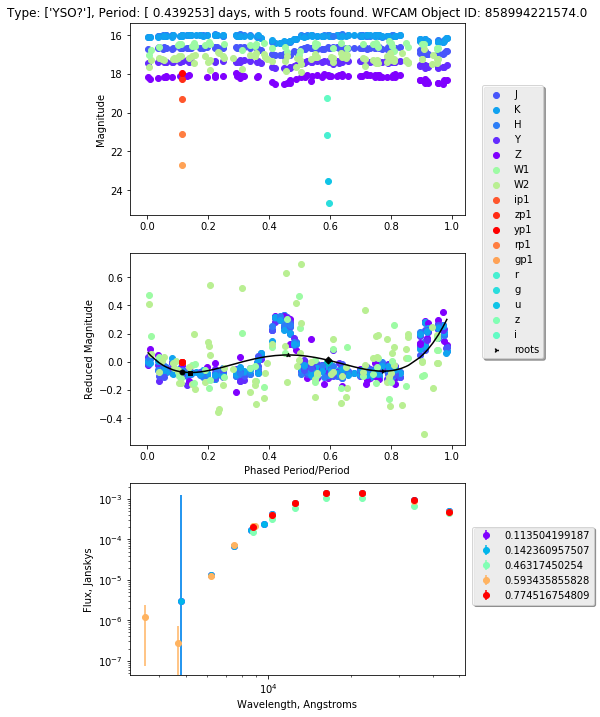

H 0.0007767661628447147 3.367281719843836e-05
J 0.0006765547967414458 3.0987523781716974e-05
K 0.0005541620967459332 2.4579704454874706e-05
Y 0.0005999756631209441 2.817488322142212e-05
Z 0.000508053810434132 2.461473377746638e-05
end root data
858994137609.0
H 0.0008723799935686215 3.869258547836004e-05
J 0.0007655146532632293 3.549217118889589e-05
K 0.0006295557856031466 2.886743390559656e-05
Y 0.0006592381950704372 3.1117936537854863e-05
Z 0.0005529003202424403 2.5266237380958567e-05
end root data
858994137609.0
H 0.0008536744865006413 3.71333324934732e-05
J 0.0007611950344388828 3.336731945297512e-05
K 0.0006224392689595289 2.7681673859189658e-05
Y 0.0006680847901003661 2.9037538869941443e-05
Z 0.000557372127741435 2.5441850307545064e-05
gp1 0.00010646968175750096 5.241984176630261e-07
ip1 0.00039666740721380626 1.6274775544279242e-06
rp1 0.0002486717952393287 8.162158747198012e-07
yp1 0.0006149310892170373 2.270687875225376e-06
zp1 0.0005110064299740574 1.2579579350022858e-06
end 

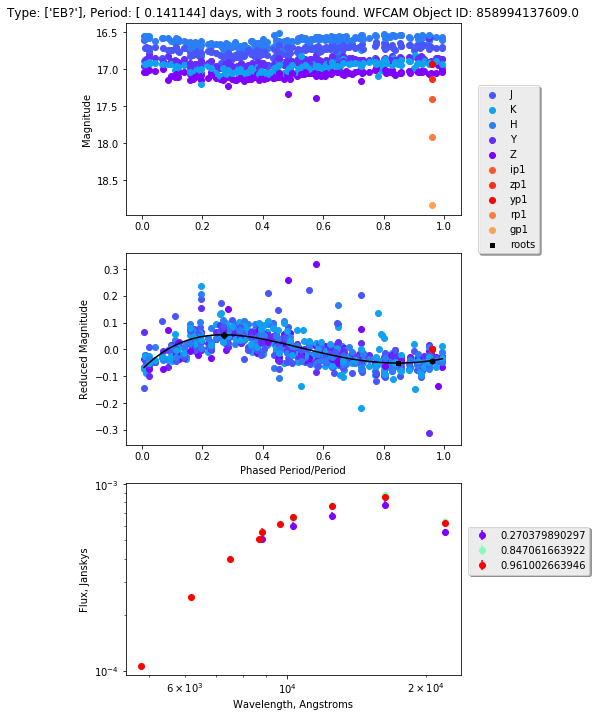

In [18]:
primary_visualizer_all_data(2)

In [ ]:
print(len(set(found_variable_stars.WSA).intersection(sdss_df.SOURCEID)))
print(len(set(found_variable_stars.WSA).intersection(wise_df.SOURCEID)))
print(len(set(wise_df.SOURCEID).intersection(sdss_df.SOURCEID)))

# Include + Combine Temperature and Spectra data etc from sdss spectra

http://www.sdss.org/dr14/spectro/sspp_changes/

C:\Users\Aaron\Anaconda3\envs\NewPhDEnv\lib\site-packages\astroquery\sdss\__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "
C:\Users\Aaron\Anaconda3\envs\NewPhDEnv\lib\site-packages\astropy\table\table.py:2628: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  result = self.as_array() == other


{'star_O': 0, 'star_OB': 1, 'star_B': 2, 'star_A': [3, 4], 'star_FA': 5, 'star_F': [6, 7], 'star_G': [8, 9], 'star_K': 10, 'star_M1': 11, 'star_M3': 12, 'star_M5': 13, 'star_M8': 14, 'star_L1': 15, 'star_wd': [16, 20, 21], 'star_carbon': [17, 18, 19], 'star_Ksubdwarf': 22, 'galaxy_early': 23, 'galaxy': [24, 25, 26], 'galaxy_late': 27, 'galaxy_lrg': 28, 'qso': 29, 'qso_bal': [30, 31], 'qso_bright': 32}
  SOURCEID  
------------
858993461311
858993464444
858993475542
858993476434
858993477934
858993478382
858993479072
858993484033
858993534207
858993535184
         ...
858994440242
858994440327
858994446505
858994451885
858994466023
858994470344
858994483134
858994488202
858994500379
858994708201
858994711814
Length = 334 rows
hi
<SkyCoord (ICRS): (ra, dec) in deg
    ( 146.28355094,  59.53943411)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 145.56010705,  59.04658944)>
      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- 

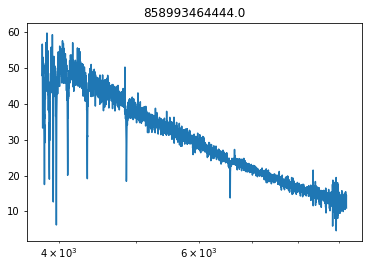

<SkyCoord (ICRS): (ra, dec) in deg
    ( 52.94948613,  37.78086835)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 52.78812833,  37.8956857)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 53.34525522,  37.87284254)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 53.42409671,  37.81507131)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 53.5377448,  37.85398108)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 9.49154182,  37.78178981)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 53.47616737,  37.38968231)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 53.32984706,  37.25660299)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 52.95232094,  37.39372709)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 52.91212412,  37.39637354)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 9.6026651,  37.34032349)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 9.54117042,  37.20630334)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 9.15125417,  37.29347182)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 224.

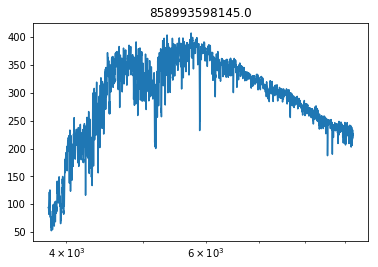

<SkyCoord (ICRS): (ra, dec) in deg
    ( 250.22036007,  36.68740602)>
      ra           dec             objid        ... run2d  instrument
------------- ------------- ------------------- ... ------ ----------
250.220302705 36.6873967154 1237659330853798002 ...     26       SDSS
250.220302705 36.6873967154 1237659330853798002 ... v5_7_0       BOSS
      ra           dec             objid        ... run2d  instrument
------------- ------------- ------------------- ... ------ ----------
250.220302705 36.6873967154 1237659330853798002 ...     26       SDSS
250.220302705 36.6873967154 1237659330853798002 ... v5_7_0       BOSS
[ 40.84796524  39.56961823  29.71365166 ...,   8.49427128   7.59328604
   8.13070011]
[ 3.57999992  3.58010006  3.58019996 ...,  3.96359992  3.96370006
  3.96379995]
[ 0.04330273  0.04375565  0.04591852 ...,  0.79113632  0.78865075
  0.75869828]


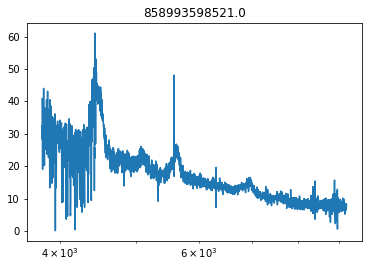

<SkyCoord (ICRS): (ra, dec) in deg
    ( 250.3995154,  36.46462102)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 246.50109057,  34.88940733)>
     ra           dec             objid        ... run2d instrument
------------ ------------- ------------------- ... ----- ----------
246.50104757 34.8893723175 1237659120408789125 ...    26       SDSS
     ra           dec             objid        ... run2d instrument
------------ ------------- ------------------- ... ----- ----------
246.50104757 34.8893723175 1237659120408789125 ...    26       SDSS
[ 186.62472534  197.71366882  184.31445312 ...,   46.01072311   40.87013245
   38.58785248]
[ 3.58030009  3.58039999  3.58049989 ...,  3.96399999  3.96409988
  3.96420002]
[ 0.01308804  0.01284888  0.01349256 ...,  0.23525952  0.25948292
  0.2676363 ]


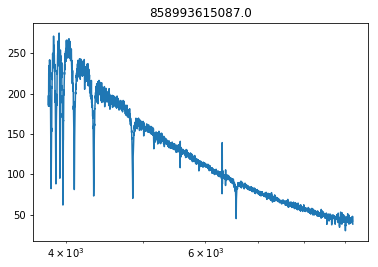

<SkyCoord (ICRS): (ra, dec) in deg
    ( 247.12327209,  34.5302604)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 135.66748759,  34.32964813)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.03539157,  30.85198523)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.04745012,  30.8855634)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.10923428,  30.942425)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.00418343,  31.01353671)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 315.93973253,  31.01745922)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 315.86862704,  31.05543023)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.39293496,  30.96508479)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.47854927,  31.05443012)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.52996458,  30.83519174)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.546634,  30.9205316)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 316.62387319,  31.00522194)>
None
<SkyCoord (ICRS): (ra, dec) in d

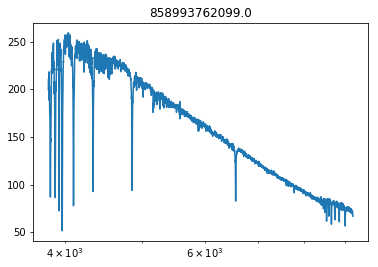

<SkyCoord (ICRS): (ra, dec) in deg
    ( 205.39186639,  28.50694474)>
      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- ... ----- ----------
205.391864268 28.5069180982 1237665442056699985 ...   103       SDSS
205.391864268 28.5069180982 1237665442056699985 ...    26       SDSS
      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- ... ----- ----------
205.391864268 28.5069180982 1237665442056699985 ...   103       SDSS
205.391864268 28.5069180982 1237665442056699985 ...    26       SDSS
[ 234.45574951  237.33171082  232.90490723 ...,   54.49825287   52.78028107
   50.06523895]
[ 3.58080006  3.58089995  3.58100009 ...,  3.96429992  3.96440005
  3.96449995]
[ 0.00633505  0.00636865  0.00678447 ...,  0.10219245  0.10452217
  0.10524663]


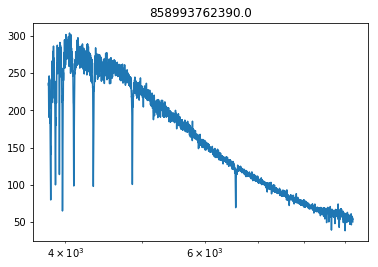

<SkyCoord (ICRS): (ra, dec) in deg
    ( 205.38224033,  28.40303088)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.82598736,  26.68764511)>
      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- ... ----- ----------
65.8259579619 26.6876203069 1237660750871593121 ...    26       SDSS
      ra           dec             objid        ... run2d instrument
------------- ------------- ------------------- ... ----- ----------
65.8259579619 26.6876203069 1237660750871593121 ...    26       SDSS
[  2.80207205  -1.85594463  -2.91636968 ...,  63.88507462  60.7135582
  69.23886108]
[ 3.57949996  3.5796001   3.57969999 ...,  3.96379995  3.96390009
  3.96399999]
[ 0.0892222   0.09907912  0.09581463 ...,  0.08255641  0.08651581
  0.07670073]


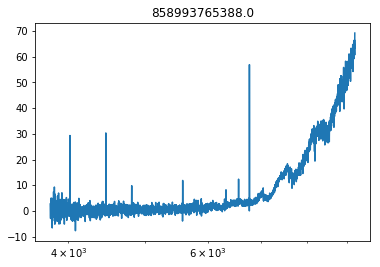

<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.80607804,  26.74621132)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.97802333,  26.7701032)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 66.41361835,  26.11954129)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.9621276,  26.23997218)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.90435003,  26.1200003)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 194.64509403,  21.68444322)>
      ra           dec             objid        ... run2d  instrument
------------- ------------- ------------------- ... ------ ----------
194.645062699 21.6844629299 1237667734512795887 ... v5_7_0       BOSS
      ra           dec             objid        ... run2d  instrument
------------- ------------- ------------------- ... ------ ----------
194.645062699 21.6844629299 1237667734512795887 ... v5_7_0       BOSS
[ 7.62487602  7.13534498  6.64595556 ...,  4.12675619  4.6657753
 -3.75267863]
[ 3.55430007  3.55439997  3.5545001  ...,  4.01450014  4.0145998

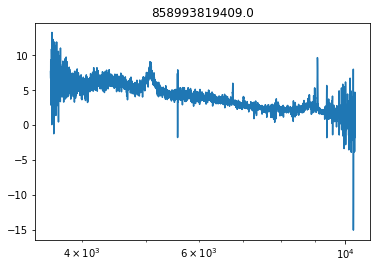

<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.00735263,  17.27937627)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 65.39216392,  17.11320766)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.67229498,  16.2312641)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.75716763,  16.25478203)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.66723396,  16.30731419)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.74451075,  16.33732044)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.57143924,  16.3562008)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.68202953,  16.39748221)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 87.74091314,  16.43167604)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 88.08326349,  16.41667201)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 88.08908429,  16.28354762)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 88.08939582,  16.29856769)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 88.1264548,  16.36752674)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 

<SkyCoord (ICRS): (ra, dec) in deg
    ( 327.55598628,  2.27646213)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 276.93595582,  1.5605625)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 276.95278792,  1.57143396)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.10287532,  1.57576272)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 276.97976551,  1.60774131)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.00916489,  1.61647402)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.08147367,  1.62836615)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.13049753,  1.62668019)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.01441869,  1.65524278)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.12343902,  1.65560267)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 276.95241341,  1.67413164)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.12782948,  1.69966798)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 277.04947829,  1.70922941)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    

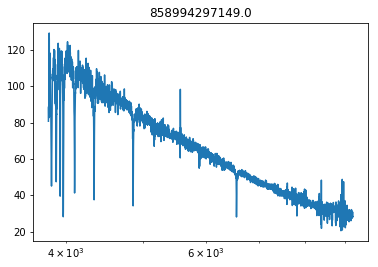

<SkyCoord (ICRS): (ra, dec) in deg
    ( 185.3197137,  0.36746776)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.1606488, -0.05998803)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.43548331, -0.12803029)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.4944375, -0.2137593)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.58215014, -0.21497908)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.60532508, -0.65799465)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.08970421, -0.62614576)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 111.04202138, -0.64184474)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.60171585, -0.55376536)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.76529764, -0.52688411)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.68238584, -0.50287146)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 96.04472957, -0.65237133)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 96.06405787, -0.51194378)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 96.073

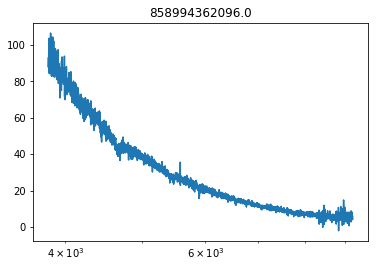

<SkyCoord (ICRS): (ra, dec) in deg
    ( 96.18140782, -1.08900367)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 96.22020815, -1.11567075)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.74117685, -1.06124245)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.64845584, -1.14382645)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.5930441, -1.09983193)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 95.58701169, -1.08192135)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 349.59747622, -2.35200767)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 349.02225353, -2.37890289)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 227.61863949, -3.0156312)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 227.54550602, -3.01596959)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 227.50113833, -3.09231206)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 104.84852523, -4.54568822)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 105.03096627, -4.5199041)>
None
<SkyCoord (ICRS): (ra, dec) in deg
    ( 104.90

In [9]:
from astroquery.sdss import SDSS
print(SDSS.AVAILABLE_TEMPLATES)
template1 = SDSS.get_spectral_template('qso')
template2 = SDSS.get_spectral_template('star_M3')
#print(template1,template2)
from astroquery.sdss import SDSS
from astropy import coordinates as coords
dat = Table.read('wfcam_positions_for_panstarrs.fits', format='fits')
print(dat['SOURCEID'])
for thing in dat['SOURCEID']:
    if thing == 858993765388.0:
        print("hi")

wfcam_pos_df = dat.to_pandas()
#wfcam_pos_df['SOURCEID'] = dat['SOURCEID']

def sdss_spectra(object_id):
    single_spectra_row = wfcam_pos_df.loc[wfcam_pos_df['SOURCEID']==object_id]
    c=coord.SkyCoord(single_spectra_row.WFCAM_RA,single_spectra_row.WFCAM_DEC,unit=(u.deg,u.deg),frame='icrs')
    xid = SDSS.query_region(c, spectro=True)
    if xid != None:
        print(xid)
        sp = SDSS.get_spectra(matches=xid)
        #print(sp[0][1].data['flux'])
        #print(sp[0][1].data['loglam'])
        #print(sp[0][1].data['ivar'])
        plt.plot(np.power(10,sp[0][1].data['loglam']),sp[0][1].data['flux'])
        plt.title(object_id)
        plt.xscale('log')
        plt.show()

#print(wfcam_pos_df)
#print(wfcam_pos_df['SOURCEID']==858993765388.0)
#wfcam_pos_df.loc[wfcam_pos_df['SOURCEID']==858993765388.0]
#sdss_spectra()
        
breaker=0
for index,row in wfcam_pos_df.iterrows():
    if breaker > 350:
        break
    #if row.SOURCEID != 858993765388.0 and row.SOURCEID != 858994221574.0:
    #    continue
    #print("now")
    
    
    c=coord.SkyCoord(row.WFCAM_RA,row.WFCAM_DEC,unit=(u.deg,u.deg),frame='icrs')
    print(c)
    xid = SDSS.query_region(c, spectro=True)
    print(xid)
    if xid != None:
        print(xid)
        sp = SDSS.get_spectra(matches=xid)
        #print(sp[0][1].data.names)
        print(sp[0][1].data['flux'])
        print(sp[0][1].data['loglam'])
        print(sp[0][1].data['ivar'])
        #print(max(np.sqrt(1/(sp[0][1].data['ivar']))))
        #print(max(sp[0][1].data['flux']))
        "inverse variance so sigma=(1/ivar)^0.5"
        #plt.plot(np.arange(len(sp[0][1].data)),sp[0][1].data)
        plt.plot(np.power(10,sp[0][1].data['loglam']),sp[0][1].data['flux'])
        plt.title(row.SOURCEID)
        plt.xscale('log')
        plt.show()
        #for counter in np.arange(1,18,1):
        #    #print(sp[0][counter].data.names)
        #    if counter != 2 and counter != 3:
        #        plt.plot(np.arange(len(sp[0][counter].data)),sp[0][counter].data)
        #        plt.show()
    breaker += 1

In [19]:
dat = Table.read('wfcam_positions_for_panstarrs.fits', format='fits')
wfcam_pos_df = dat.to_pandas()
#print(wfcam_pos_df)
wfcam_pos_df.loc[wfcam_pos_df['SOURCEID']==858994221574.0]

,SOURCEID,WFCAM_RA,WFCAM_DEC
248,8.589942e+11,277.096939,1.252038
